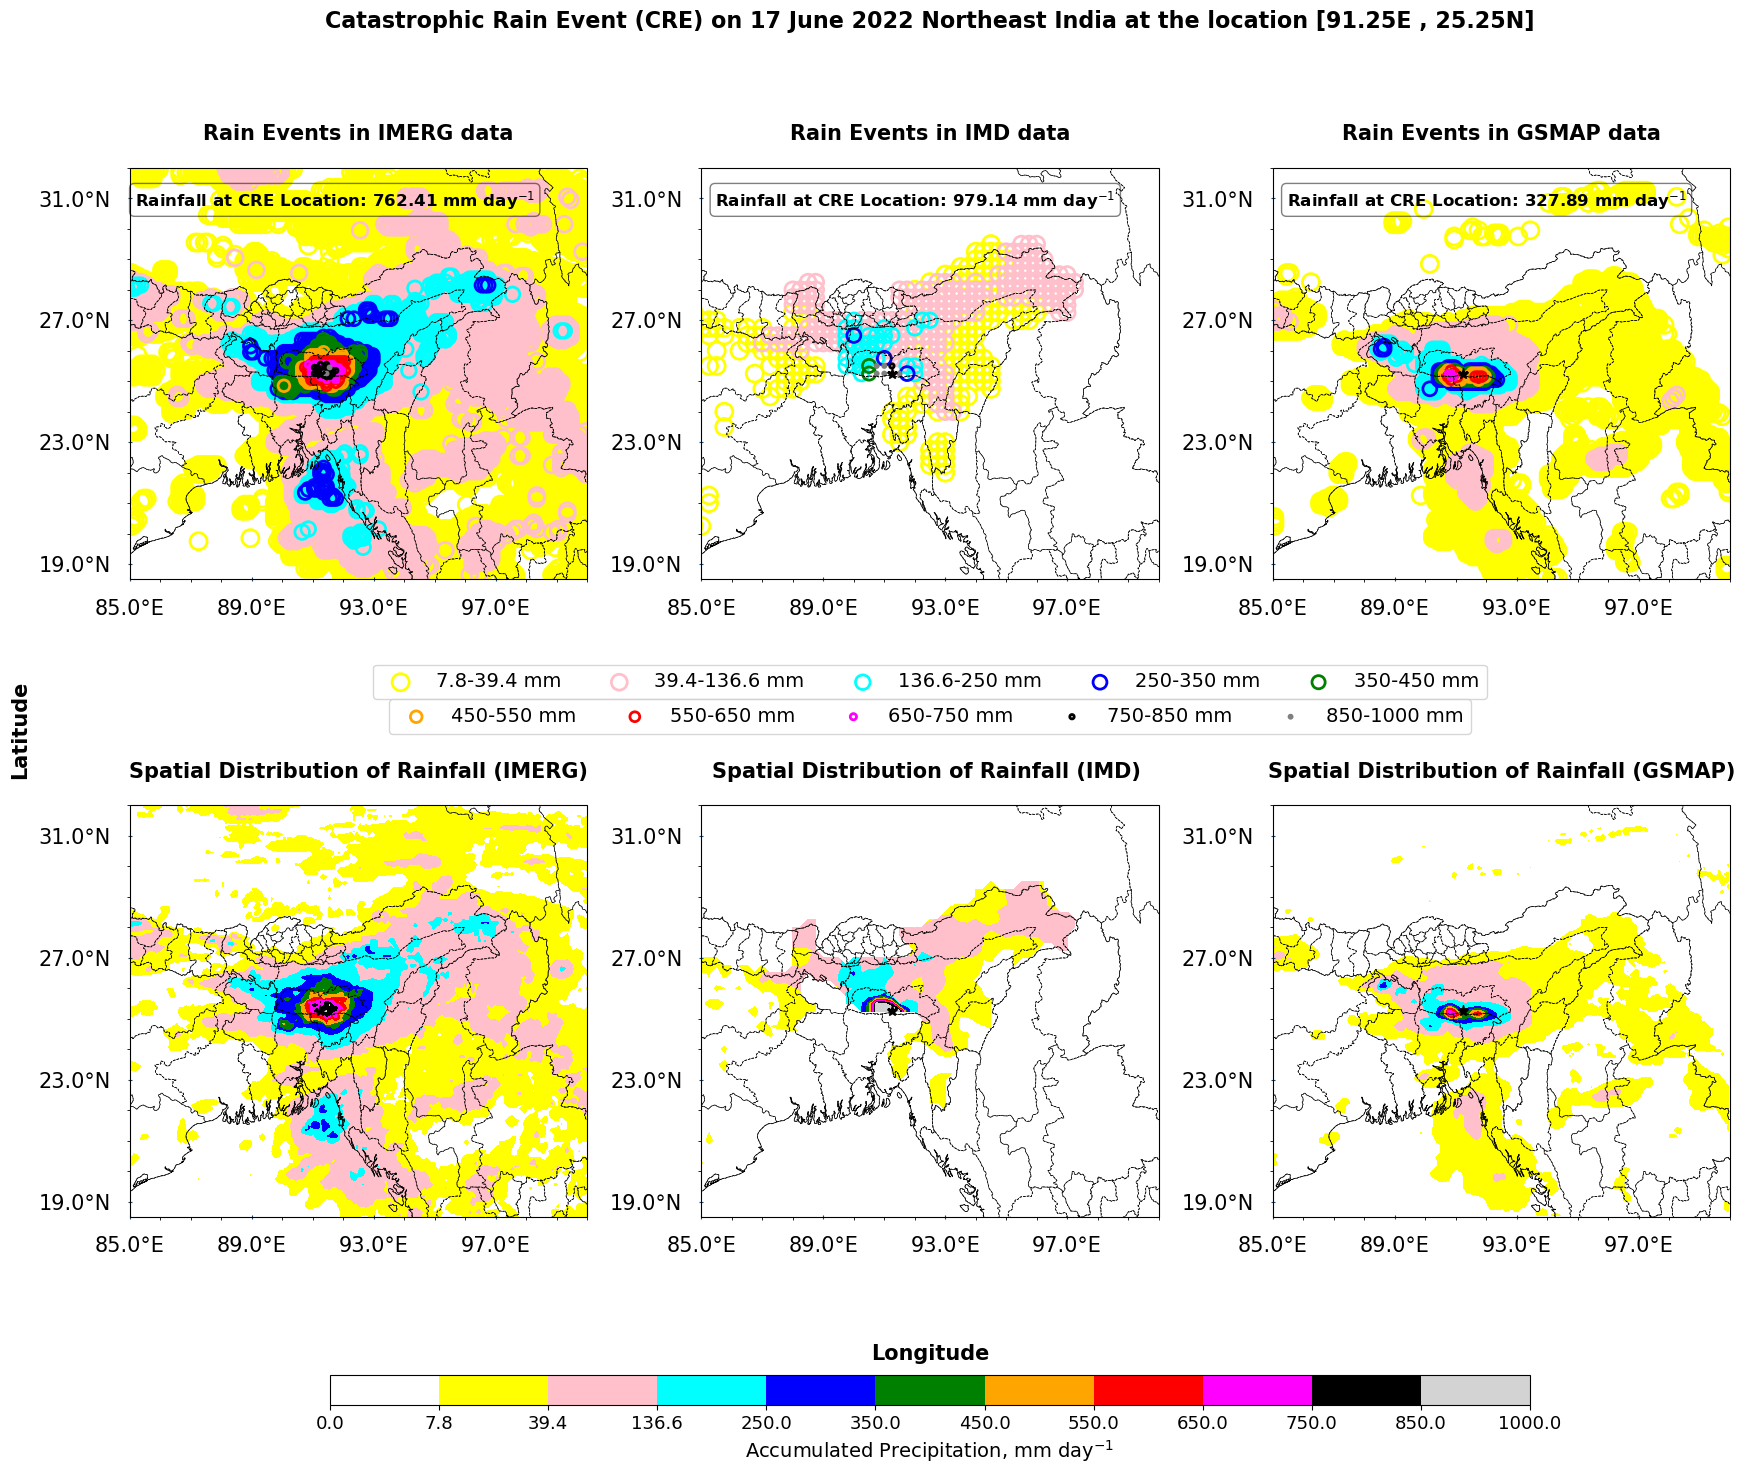

In [79]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define rain event categories
rain_ranges = {
    'Background rain': (0, 7.8),
    'Moderate Rain Events': (7.8, 39.4),
    'Intense Rain Events': (39.4, 136.6),
    'Extreme Rain Events': (136.6, np.inf)
}

# Function to determine the type of rain event
def determine_rain_type(precipitation):
    for event, (min_val, max_val) in rain_ranges.items():
        if min_val <= precipitation < max_val:
            return event
    return None

# Read data from CSV (df_1) IMERG
data_0 = xr.open_mfdataset("/home/pc/Desktop/New Folder/Accumulated rain data/2022/*.nc4")
time_1 = data_0.variables['time'][:]
lat = data_0.variables['lat'][:]
lon = data_0.variables['lon'][:]
prep = data_0.variables['precipitation'][:]
accumulated_rainfall = np.sum(prep, axis=0)
data_1 = pd.read_csv('rainfall_data_2022.csv')
df_1 = pd.DataFrame(data_1)

# Filter the data for the northeast region of India (df_1)
northeast_df = df_1.loc[(df_1['Latitude'] >= 18.5) & (df_1['Latitude'] <= 32) & (df_1['Longitude'] >= 85) & (df_1['Longitude'] <= 100)]
filtered_df_1 = northeast_df.loc[northeast_df['Accumulated Precipitation'] >= 7.8]

# Define the categories and corresponding colors
categories = [
    (7.8, 39.4, 'yellow', 150),
    (39.4, 136.6, 'pink', 130),
    (136.6, 250, 'cyan', 110),
    (250, 350, 'blue', 100),
    (350, 450, 'green', 90),
    (450, 550, 'orange', 70),
    (550, 650, 'red', 50),
    (650, 750, 'magenta', 20),
    (750, 850, 'black', 10),
    (850, 1000, 'grey',5)
]

# Read data from NetCDF IMD
data_2 = xr.open_dataset("/home/pc/Desktop/IMD_Data/RF25_ind2022_rfp25.nc")

# Extract necessary variables from data_2
latitude = data_2['LATITUDE']
longitude = data_2['LONGITUDE']
rainfall = data_2['RAINFALL']
time_2 = data_2['TIME']
Acc_Rain = rainfall[167, :, :]  # Assuming this is the specific time step you need
# Read GSMAP data
data_3 = xr.open_dataset("/home/pc/Desktop/GSMAP_data/2022/accumulated_rainfall_2022.nc")
lat_3 = data_3['Latitude']
lon_3 = data_3['Longitude']
Acc_rainfall = data_3['hourlyPrecipRate']
# Convert to numpy arrays
latitude_np = latitude.values
longitude_np = longitude.values
Acc_Rain_np = Acc_Rain.values

# Prepare the data for the dataframe
data = []
lat_len = len(latitude_np)
lon_len = len(longitude_np)

for i in range(lat_len):
    for j in range(lon_len):
        lat_val = latitude_np[i]
        lon_val = longitude_np[j]
        precipitation = Acc_Rain_np[i, j]
        rain_type = determine_rain_type(precipitation)
        data.append((lat_val, lon_val, precipitation, rain_type))

# Create the dataframe
df_2 = pd.DataFrame(data, columns=['Latitude', 'Longitude', 'Accumulated Precipitation', 'Rain Event Type'])
# Read GSMAP data from CSV
csv_file_path = "/home/pc/Desktop/GSMAP_data/2022/accumulated_rainfall_2022_categories.csv"
df_3 = pd.read_csv(csv_file_path)

# Define levels and colors
levels = [0, 7.8, 39.4, 136.6, 250, 350, 450, 550, 650, 750, 850,1000]
colors = ['white','yellow', 'pink', 'cyan', 'blue', 'green', 'orange', 'red', 'magenta', 'black', 'lightgrey']
# Create the colormap and norm
cmap = ListedColormap(colors)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Create a figure with 6 subplots arranged in 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust layout for the entire figure
fig.subplots_adjust(hspace=0, wspace=0.25, top=0.95, bottom=0.1, left=0.1, right=0.9)

def setup_map(ax, labels_with_direction=False):
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle='--', linewidth=0.5)
    ax.set_xlim(85, 100)
    ax.set_ylim(18.5, 32)
    ax.set_xticks(range(85, 101, 4))  # Set xticks with an interval of 2 degrees
    ax.set_yticks(range(19, 32, 4))   # Set yticks with an interval of 2 degrees
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor ticks for x-axis
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor ticks for y-axis
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1f}°E'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1f}°N'))
    # Set tick labels to bold
    ax.tick_params(axis='both', which='major', labelsize=15, direction='inout', pad=12, color='#234567')
    return ax

# Define marker properties
marker_lat = 25.25
marker_lon = 91.25
marker_style = {'marker': '*', 'color': 'black', 'markersize': 8}

# Plotting for df_1
# Subplot 1: Scatter plot for df_1
ax1 = axes[0, 0]
setup_map(ax1)
ax1.set_title('Rain Events in IMERG data', fontsize=15, fontweight='bold', pad=20)  # Increase pad for title
handles_ax1 = []
for lower, upper, color, size in categories:
    category_df = filtered_df_1[(filtered_df_1['Accumulated Precipitation'] > lower) & (filtered_df_1['Accumulated Precipitation'] <= upper)]
    if not category_df.empty:
        sc = ax1.scatter(category_df['Longitude'], category_df['Latitude'], color=color, s=size, edgecolor=color, facecolors='none', linewidth=2, label=f'{lower}-{upper} mm')
        handles_ax1.append(sc)
ax1.plot(marker_lon, marker_lat, **marker_style)

# Plotting for df_2
# Subplot 3: Scatter plot for df_2
ax2 = axes[0, 1]
setup_map(ax2)
ax2.set_title('Rain Events in IMD data', fontsize=15, fontweight='bold', pad=20)  # Increase pad for title
handles_ax2 = []
for lower, upper, color, size in categories:
    category_df_2 = df_2[(df_2['Accumulated Precipitation'] > lower) & (df_2['Accumulated Precipitation'] <= upper)]
    if not category_df_2.empty:
        sc = ax2.scatter(category_df_2['Longitude'], category_df_2['Latitude'], color=color, s=size, edgecolor=color, facecolors='none', linewidth=2, label=f'{lower}-{upper} mm')
        handles_ax2.append(sc)
    else:
        # Create a dummy scatter plot to include in the legend
        sc = ax2.scatter([], [], color=color, s=size, edgecolor=color, facecolors='none', linewidth=2, label=f'{lower}-{upper} mm')
        handles_ax2.append(sc)
ax2.plot(marker_lon, marker_lat, **marker_style)

# Subplot 3: Scatter plot for df_3
ax3 = axes[0, 2]
setup_map(ax3)
ax3.set_title('Rain Events in GSMAP data', fontsize=15, fontweight='bold', pad=20)  # Increase pad for title
handles_ax3 = []
for lower, upper, color, size in categories:
    category_df_3 = df_3[(df_3['Rainfall'] > lower) & (df_3['Rainfall'] <= upper)]
    if not category_df_3.empty:
        sc = ax3.scatter(category_df_3['Longitude'], category_df_3['Latitude'], color=color, s=size, edgecolor=color, facecolors='none', linewidth=2, label=f'{lower}-{upper} mm')
        handles_ax3.append(sc)
    else:
        # Create a dummy scatter plot to include in the legend
        sc = ax3.scatter([], [], color=color, s=size, edgecolor=color, facecolors='none', linewidth=2, label=f'{lower}-{upper} mm')
        handles_ax3.append(sc)
ax3.plot(marker_lon, marker_lat, **marker_style)

# Combine and deduplicate handles and labels
combined_handles = []
combined_labels = []
for handles in [handles_ax1, handles_ax2, handles_ax3]:
    for handle in handles:
        label = handle.get_label()
        if label not in combined_labels:
            combined_labels.append(label)
            combined_handles.append(handle)

# Sort handles and labels according to the first value in categories
sorted_handles_labels = sorted(zip(combined_handles, combined_labels), key=lambda x: float(x[1].split('-')[0]))

# Unpack sorted handles and labels
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Split sorted handles and labels into two lines
first_line_handles = sorted_handles[:5]
first_line_labels = sorted_labels[:5]
second_line_handles = sorted_handles[5:10]
second_line_labels = sorted_labels[5:10]

# Create the legend with two lines
fig.legend(first_line_handles, first_line_labels, loc='upper center', fontsize=14, frameon=True, ncol=5, bbox_to_anchor=(0.5, 0.55))
fig.legend(second_line_handles, second_line_labels, loc='upper center', fontsize=14, frameon=True, ncol=5, bbox_to_anchor=(0.5, 0.527))

# Subplot 2: Contour plot for df_1
ax4 = axes[1, 0]
setup_map(ax4)
ax4.set_title('Spatial Distribution of Rainfall (IMERG)', fontsize=15, fontweight='bold', pad=20)  # Increase pad for title
contour_df_1 = ax4.contourf(lon[250:401], lat[135:275], accumulated_rainfall[250:401, 135:275].T, levels=levels, cmap=cmap, norm=norm)
ax4.plot(marker_lon, marker_lat, **marker_style)

# Subplot 4: Contour plot for df_2
ax5 = axes[1, 1]
setup_map(ax5)
ax5.set_title('Spatial Distribution of Rainfall (IMD) ', fontsize=15, fontweight='bold', pad=20)  # Increase pad for title
contour_df_2 = ax5.contourf(longitude[74:135], latitude[48:97], Acc_Rain[48:97, 74:135], levels=levels, cmap=cmap, norm=norm)
ax5.plot(marker_lon, marker_lat, **marker_style)

# Subplot 6: Contour plot for df_3 (GSMAP)
ax6 = axes[1, 2]
setup_map(ax6)
ax6.set_title('Spatial Distribution of Rainfall (GSMAP)', fontsize=15, fontweight='bold', pad=20)  # Increase pad for title
# Assuming df_3 contains GSMAP data in 'Rainfall' column
contour_df_6 = ax6.contourf(lon_3,lat_3 ,Acc_rainfall, levels=levels, cmap=cmap, norm=norm)
ax6.plot(marker_lon, marker_lat, **marker_style)
# Adding a single color bar for the contour plots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # Position: [left, bottom, width, height]
cbar = fig.colorbar(contour_df_1, cax=cbar_ax, orientation='horizontal', extend='both')

cbar.set_label('Accumulated Precipitation, mm day$^{-1}$', fontsize=14)
cbar.ax.tick_params(labelsize=13)  # Adjust the font size here
cbar.set_ticks(levels)  # Set ticks to match the contour levels
cbar.ax.set_xticklabels([f'{l:.1f}' for l in levels])  # Format tick labels
# Set common x-axis and y-axis labels for the entire figure
fig.text(0.5, 0.08, 'Longitude', ha='center', fontsize=15, fontweight='bold')
fig.text(0.04, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=15, fontweight='bold')
# Adjust the position of the suptitle above the legend
# Define the text to be displayed in each text box
textstrs = {
    'IMERG': 'Rainfall at CRE Location: 762.41 mm day$^{-1}$',
    'IMD': 'Rainfall at CRE Location: 979.14 mm day$^{-1}$',
    'GSMAP': 'Rainfall at CRE Location: 327.89 mm day$^{-1}$'
}
# Define the position and style of the text boxes
text_positions = {
    'IMERG': (0.01, 0.95),
    'IMD': (0.03, 0.95),
    'GSMAP': (0.03, 0.95)
}
# Define the style for the text boxes, including bold font
text_kwargs = dict(
    fontsize=12,
    fontweight='bold',
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='None', alpha=0.5)
)

# Add text boxes to each subplot
axes[0, 0].text(text_positions['IMERG'][0], text_positions['IMERG'][1], textstrs['IMERG'], transform=axes[0, 0].transAxes, **text_kwargs)
axes[0, 1].text(text_positions['IMD'][0], text_positions['IMD'][1], textstrs['IMD'], transform=axes[0, 1].transAxes, **text_kwargs)
axes[0, 2].text(text_positions['GSMAP'][0], text_positions['GSMAP'][1], textstrs['GSMAP'], transform=axes[0, 2].transAxes, **text_kwargs)
# # Define the position and style of the text box
# plt.text(-0.15, 23, textstr, transform=plt.gca().transAxes, 
#          fontsize=14, verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='None', alpha=0.5))
fig.suptitle('Catastrophic Rain Event (CRE) on 17 June 2022 Northeast India at the location [91.25E , 25.25N]', fontsize=16, fontweight='bold')
#plt.tight_layout()
# Save the plot to a file
plt.savefig('GSMAP_2022.png')

plt.show()
